In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
data_dir = os.getcwd() + '/../../../../QTDataBase/'        # data (records) directory
data_files = os.listdir(data_dir)                       # get a listing of the directory, i.e. the records names
dat_files = [x.split('.')[0] for x in data_files]
#----- ---- --- -- -
file_name = 'sel100' # 'sel100' 'sel47' 'sel301' 'sel301', 'sele0126'                        
                                                        # 'sele0603' 'sele0612' 'sel41' 'sele0122'
                                                        # 'sel40' 'sele0303' 'sel14046'
                                                        #--------    
                                                        # 'sele0112', 'sel114' 
            
            
#'sel30', 'sel47', 'sel14046', 'sele0603', 'sel16786', 'sel123', 'sel37', 'sele0166', 'sele0509', 'sel811', 
#'sel16273', 'sel16795', 'sel50', 'sel307', 'sel44', 'sel41', 'sele0409', 'sel873', 'sele0110', 'sele0104',
#'sele0122', 'sele0136', 'sel221', 'sele0111', 'sel16420', 'sel42', 'sele0210', 'sel232', 'sele0606', 
#'sele0612', 'sele0116', 'sele0607', 'sel233', 'sel117', 'sel871', 'sele0211', 'sel43', 'sele0406', 'sel45',
#'sel16539', 'sel51', 'sel15814', 'sele0411', 'sel308', 'sel872', 'sel40', 'sele0405', 'sele0604', 'sel301',
#'sel306', 'sele0203', 'sel16483', 'sel16272', 'sel14172', 'sel36', 'sel17453', 'sel104', 'sele0704', 'sele0170',
#'sel17152', 'sel52', 'sel46', 'sel31', 'sel803', 'sel853', 'sel847', 'sel33', 'sel49', 'sel820', 'sel808',
#'sel16773', 'sel34', 'sel310', 'sel230', 'sele0107', 'sel103', 'sele0121', 'sel213', 'sel231', 'sele0114',
#'sele0303', 'sele0609', 'sele0129', 'sel223', 'sele0112', 'sele0106', 'sel35', 'sel16265', 'sel14157', 'sel821',
#'sel891', 'sel48', 'sel32', 'sele0124', 'sel102', 'sel116', 'sel100', 'sel114', 'sel302', 'sele0133', 'sele0126',
#'sel883', 'sel840', 'sel38', 'sel39'            
                        
            
file_to_read = data_dir + file_name
#----- ---- --- -- -
import wfdb
signals, fields = wfdb.rdsamp(file_to_read, sampfrom = 0)
fs = fields["fs"]
ch_num = 0
s = signals[:, ch_num]
#----- ---- --- -- -
n_sec = 30
N = n_sec * fs
ecg_clean = s[0 : N]
import numpy as np    
#ecg_clean = ecg_clean - np.mean(ecg_clean)
#ecg_clean = ecg_clean/np.max(np.abs(ecg_clean))
#----- ---- --- -- -
# Baseline wander removal.
#%run BaselineWanderRemoval.ipynb

# from BaselineWanderRemoval import BaselineWanderRemoval
# bwr, ecg_bwr = BaselineWanderRemoval(signal = ecg_clean,
#                                      win_l_MD = 0.72,
#                                      win_l_MA = 0.87,
#                                      fs = fs)

from BaselineWanderRemovalBP import BaselineWanderRemovalBP
ecg_bwr = BaselineWanderRemovalBP(signal = ecg_clean, 
                                  k_BP = 0.7, 
                                  fc1 = 5.0/fs, 
                                  fc2 = 80.0/fs)

# RPeak detection & Middles detection & RPeak reordering (w.r.t to the middles).
#%run RPeakDetector.ipynb
from RPeakDetector3 import RPeakDetector3
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = RPeakDetector3(signal = ecg_bwr,
                                                                         frac = 0.5,
                                                                         win_l_calib = 0.3,
                                                                         win_l_peak_search = 0.4,
                                                                         fs = fs)
# Middles detection & RPeak reordering (w.r.t to the middles).
#%run MiddleDetector.ipynb
from MiddleDetector import MiddleDetector
#mids = MiddleDetector(pks[1:len(pks)], len(ecg_bwr))
mids = MiddleDetector(pks, len(ecg_bwr))
#%run RPeakReordering.ipynb
from RPeakReordering import RPeakReordering
pks_re = RPeakReordering(pks, mids)
#----- ---- --- -- -
ecg = ecg_bwr[mids[0] : mids[-1]+1]                          # get the ecg, i.e. get the chunck between the first
                                                             # mid and last mid.    
#----- ---- --- -- -    
ps = np.int_(pks_re - mids[0])                                  # calibrate the peaks, by shifting with the mids[0]
                                                             # which is the begining of the signal.
ms = np.int_(mids - mids[0])                                 # calibrate the middles, by shifting with the mids[0]
                                                             # which is the begining of the signal.
beats_Rpeaks = ps - ms[:-1]                                  # the peaks relative to each heartbeat, i.e. the
                                                             # position counting from the heartbeat begining.
beats_Lenghts = ms[1:] - ms[:-1]                             # the beats length.
#----- ---- --- -- -
target_noise_db =  20                                        # set the target noise in dB
#----- ---- --- -- -
#%run AddNoise.ipynb
from AddNoise import AddNoise
ecg_n, n, var_n = AddNoise(target_noise_db, ecg)             # get the noisy signal and the added noise signal.
sd_n = np.sqrt(var_n)
#----- ---- --- -- -
#%run ECGHeartBeatsList.ipynb
from ECGHeartBeatsList import ECGHeartBeatsList
s = ECGHeartBeatsList(ecg, ms)                               # s is the "pure" ecg, as list of heartbeats.
s_f = np.concatenate(s, axis=0).tolist()                     # s_f refers to x flatten, used in plots.
#----- ---- --- -- -
x = ECGHeartBeatsList(ecg_n, ms)                             # x is the "noisy" ecg, as list of noisy heartbeats.
x_f = np.concatenate(x, axis=0).tolist()                     # x_f refers to x flatten, used in plots.
#----- ---- --- -- -
n = ECGHeartBeatsList(ecg_n - ecg, ms)                             # x is the "noisy" ecg, as list of noisy heartbeats.
n_f = np.concatenate(n, axis=0).tolist()                     # x_f refers to x flatten, used in plots.
#----- ---- --- -- -
from ComputeOptimalTau import ComputeOptimalTau
TauFirstHalf, TauSecondHalf = ComputeOptimalTau(s, beats_Rpeaks)

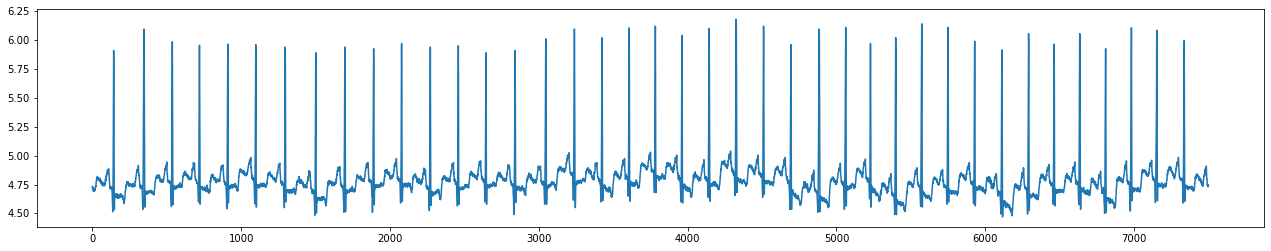

In [3]:
detail = len(ecg_clean)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 4))
plt.plot(ecg_clean[0 : detail],label = 'ecg_clean')

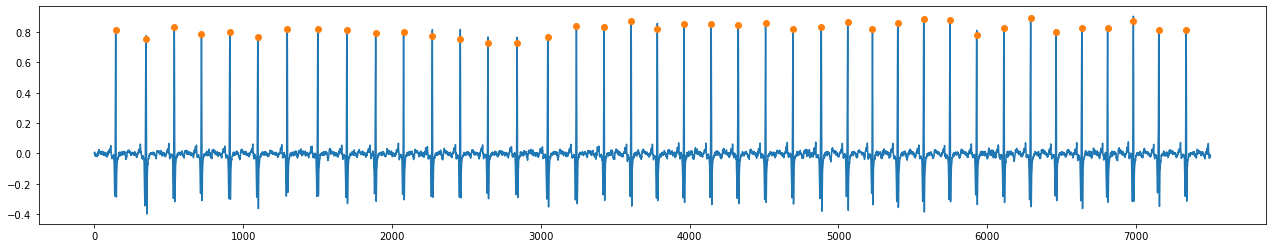

In [4]:
detail = len(ecg_bwr)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 4))
plt.plot(ecg_bwr[0 : detail],label = 'ecg_bwr')
plt.plot(peaks2[0:len(peaks2)],[ecg_bwr[i] for i in peaks2[0:len(peaks2)]],'o')

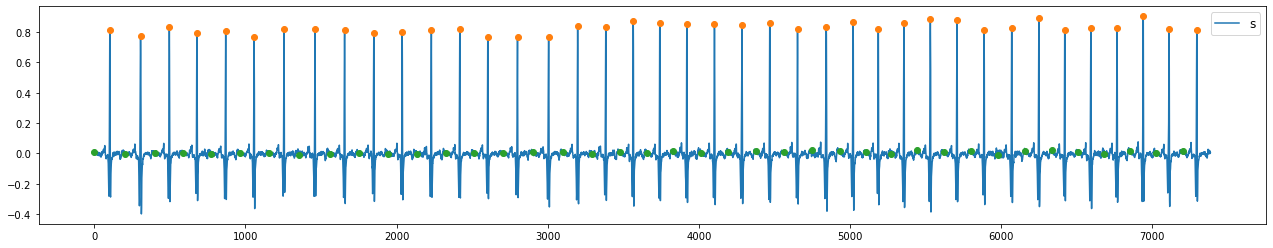

In [5]:
detail = len(s_f)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 4))
#------------
plt.plot(s_f[0 : detail],label = 's')
plt.plot(ps[0:len(ps)],[s_f[i] for i in ps[0:len(ps)]],'o')
plt.plot(ms[0:len(ms)-1],[s_f[i] for i in ms[0:len(ms)-1]],'o')
plt.legend(fontsize = 12, loc = 1)

### 1. GaussianProcessFilterInPhaseDiagFast (pure version)

In [6]:
from GaussianProcessFilterInPhaseDiagFast import GaussianProcessFilterInPhaseDiagFast
sh, mu_s, Ps, g, k_xi, k_si, k_s, mu_xi, xi = GaussianProcessFilterInPhaseDiagFast(x, beats_Rpeaks, TauFirstHalf, 
                                                                                               TauSecondHalf, fs, var_n)
sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

import skimage
import pywt
from skimage.restoration import denoise_wavelet
wv_f = denoise_wavelet(np.array(x_f), method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]
deltaSNRvalwv = ComputeInputOutputDeltaSNRs(s_f, n_f, wv_f)[2]

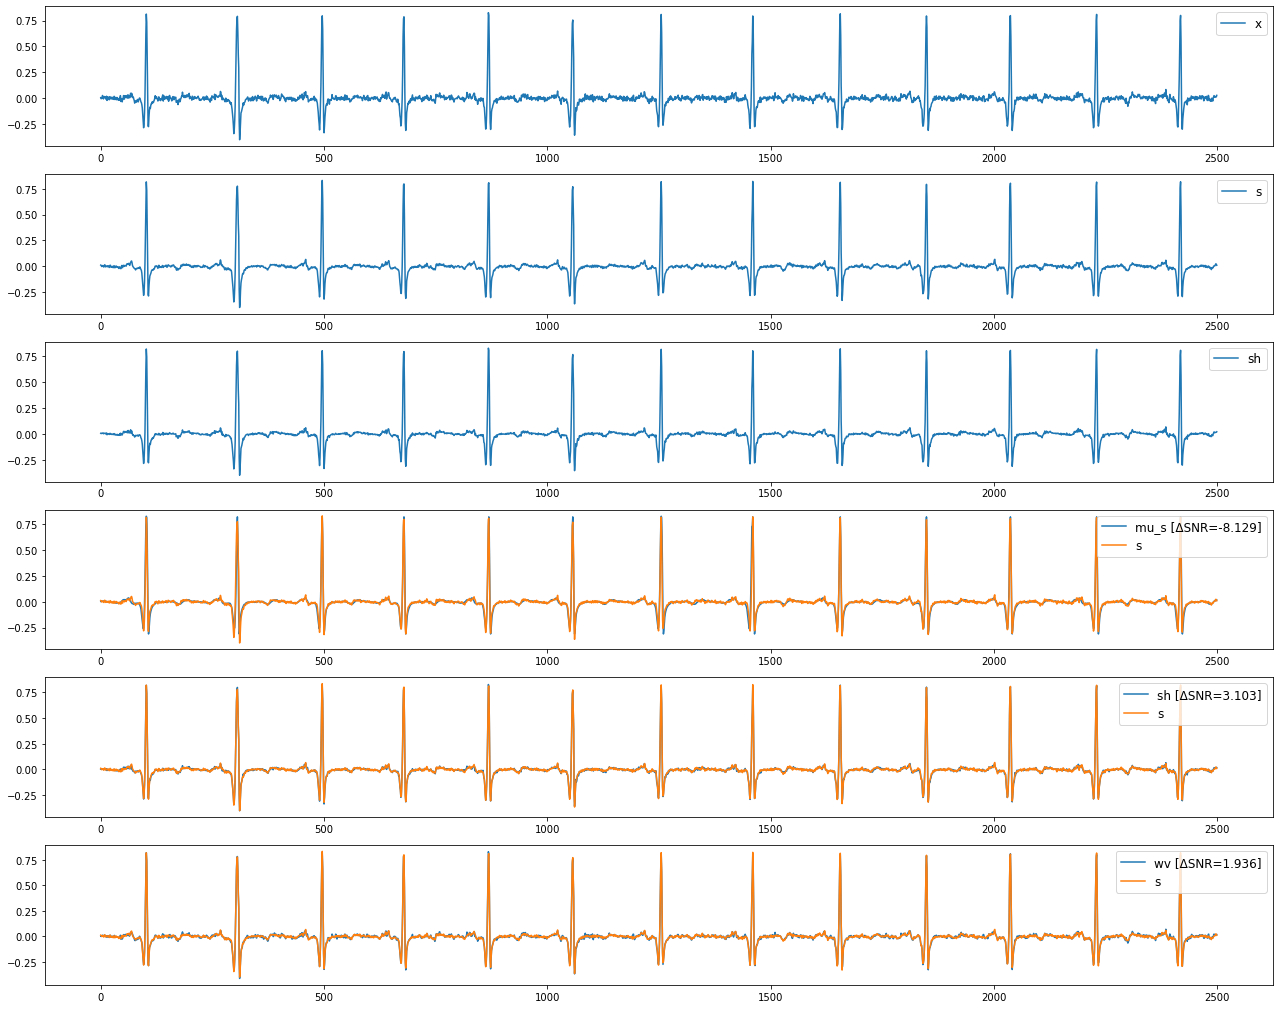

In [7]:
detail = 2500
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 18))
#------------
plt.subplot(6, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 6)
plt.plot(wv_f[0 : detail],label = 'wv [ΔSNR=' + str(np.round(deltaSNRvalwv,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [8]:
stop

NameError: name 'stop' is not defined

In [ ]:
si = []
for i in np.arange(len(s)):    
    si.append(np.matmul(Ps[i], s[i]))
    
k_si_r = np.diag(np.cov(si, rowvar = False, bias = False))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 12))
n_be = 10
#------------------------------------
plt.subplot(4,3,1)
plt.plot(x[0], label = 'x')
plt.plot(s[0], label = 's')
plt.plot(mu_s[0], label = 'mu_s')
plt.legend()

plt.subplot(4,3,2)
plt.plot(x[1], label = 'x')
plt.plot(s[1], label = 's')
plt.plot(mu_s[1], label = 'mu_s')
plt.legend()

plt.subplot(4,3,3)
plt.plot(x[2], label = 'x')
plt.plot(s[2], label = 's')
plt.plot(mu_s[2], label = 'mu_s')
plt.legend()

#------------------------------------
plt.subplot(4,3,4)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
#plt.plot(xizm[0],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()

plt.subplot(4,3,5)
plt.plot(xi[1], label = 'xi')
plt.plot(si[1], label = 'si')
#plt.plot(xizm[1],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()

plt.subplot(4,3,6)
plt.plot(xi[2], label = 'xi')
plt.plot(si[2], label = 'si')
#plt.plot(xizm[2],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()
#------------------------------------
plt.subplot(4,3,7)
for i in np.arange(n_be):
    plt.plot(xi[i])
plt.plot(mu_xi, 'b')

plt.subplot(4,3,8)
plt.plot(k_si, label = 'k_si')
plt.plot(k_xi, label = 'k_xi')
plt.legend()

#------------------------------------
plt.subplot(4,3,10)
for i in np.arange(n_be):
    plt.plot(si[i])
plt.plot(mu_xi, 'b')

plt.subplot(4,3,11)
plt.plot(k_si_r, label = 'k_si_r')
plt.plot(k_si, label = 'k_si')
plt.legend()


# plt.subplot(2,3,9)
# plt.plot(xi[1], label = 'xi')
# plt.plot(mu_xi[1], label = 's')
# plt.plot(xizm[1],'k', label = 'xim')
# plt.plot(mu_s[1], label = 'mu_s')
# plt.legend()

# plt.subplot(2,3,6)
# plt.plot(xi[2], label = 'xi')
# plt.plot(mu_xi[2], label = 's')
# plt.plot(xizm[2],'k', label = 'xim')
# plt.plot(mu_s[2], label = 'mu_s')
# plt.legend()
#------------------------------------

In [ ]:
# stop

### GaussianProcessFilterInPhaseDiagFastFilteredMean (mean is Gaussian filtered , covariance computed accordingly)

In [ ]:
from GaussianProcessFilterInPhaseDiagFastFilteredMean import GaussianProcessFilterInPhaseDiagFastFilteredMean
sigma = 1
sh, mu_s, Ps, g, k_xi, k_si, k_s, mu_xi, xi = GaussianProcessFilterInPhaseDiagFastFilteredMean(x, beats_Rpeaks, TauFirstHalf, 
                                                                                               TauSecondHalf, fs, sigma, var_n)
sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

import skimage
import pywt
from skimage.restoration import denoise_wavelet
wv_f = denoise_wavelet(np.array(x_f), method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]
deltaSNRvalwv = ComputeInputOutputDeltaSNRs(s_f, n_f, wv_f)[2]

In [ ]:
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 18))
#------------
plt.subplot(6, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 6)
plt.plot(wv_f[0 : detail],label = 'wv [ΔSNR=' + str(np.round(deltaSNRvalwv,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [ ]:
si = []
for i in np.arange(len(s)):    
    si.append(np.matmul(Ps[i], s[i]))
    
k_si_r = np.diag(np.cov(si, rowvar = False, bias = False))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 12))
n_be = 10
#------------------------------------
plt.subplot(4,3,1)
plt.plot(x[0], label = 'x')
plt.plot(s[0], label = 's')
plt.plot(mu_s[0], label = 'mu_s')
plt.legend()

plt.subplot(4,3,2)
plt.plot(x[1], label = 'x')
plt.plot(s[1], label = 's')
plt.plot(mu_s[1], label = 'mu_s')
plt.legend()

plt.subplot(4,3,3)
plt.plot(x[2], label = 'x')
plt.plot(s[2], label = 's')
plt.plot(mu_s[2], label = 'mu_s')
plt.legend()

#------------------------------------
plt.subplot(4,3,4)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
#plt.plot(xizm[0],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()

plt.subplot(4,3,5)
plt.plot(xi[1], label = 'xi')
plt.plot(si[1], label = 'si')
#plt.plot(xizm[1],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()

plt.subplot(4,3,6)
plt.plot(xi[2], label = 'xi')
plt.plot(si[2], label = 'si')
#plt.plot(xizm[2],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()
#------------------------------------
plt.subplot(4,3,7)
for i in np.arange(n_be):
    plt.plot(xi[i])
plt.plot(mu_xi, 'b')

plt.subplot(4,3,8)
plt.plot(k_si, label = 'k_si')
plt.plot(k_xi, label = 'k_xi')
plt.legend()

#------------------------------------
plt.subplot(4,3,10)
for i in np.arange(n_be):
    plt.plot(si[i])
plt.plot(mu_xi, 'b')

plt.subplot(4,3,11)
plt.plot(k_si_r, label = 'k_si_r')
plt.plot(k_si, label = 'k_si')
plt.legend()


# plt.subplot(2,3,9)
# plt.plot(xi[1], label = 'xi')
# plt.plot(mu_xi[1], label = 's')
# plt.plot(xizm[1],'k', label = 'xim')
# plt.plot(mu_s[1], label = 'mu_s')
# plt.legend()

# plt.subplot(2,3,6)
# plt.plot(xi[2], label = 'xi')
# plt.plot(mu_xi[2], label = 's')
# plt.plot(xizm[2],'k', label = 'xim')
# plt.plot(mu_s[2], label = 'mu_s')
# plt.legend()
#------------------------------------

### GaussianProcessFilterInPhaseDiagFastWaveletMean (mean is Wavelet filtered , covariance computed accordingly)

In [ ]:
from GaussianProcessFilterInPhaseDiagFastWaveletMean import GaussianProcessFilterInPhaseDiagFastWaveletMean
sh, mu_s, Ps, g, k_xi, k_si, k_s, mu_xi, xi, xizm = GaussianProcessFilterInPhaseDiagFastWaveletMean(x, beats_Rpeaks, TauFirstHalf, 
                                                                                               TauSecondHalf, fs, var_n)

sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

import skimage
import pywt
from skimage.restoration import denoise_wavelet
wv_f = denoise_wavelet(np.array(x_f), method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]
deltaSNRvalwv = ComputeInputOutputDeltaSNRs(s_f, n_f, wv_f)[2]

In [ ]:
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 18))
#------------
plt.subplot(6, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 6)
plt.plot(wv_f[0 : detail],label = 'wv [ΔSNR=' + str(np.round(deltaSNRvalwv,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [ ]:
si = []
for i in np.arange(len(s)):    
    si.append(np.matmul(Ps[i], s[i]))

sizm = []
for i in np.arange(len(s)):    
    sizm.append(si[i] - mu_xi[i])
    
k_si_r = np.diag(np.cov(sizm, rowvar = False, bias = False))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 20))
n_be = 1
#------------------------------------
plt.subplot(5,3,1)
plt.plot(x[0], label = 'x')
plt.plot(s[0], label = 's')
plt.plot(mu_s[0], label = 'mu_s')
plt.legend()

plt.subplot(5,3,2)
plt.plot(x[1], label = 'x')
plt.plot(s[1], label = 's')
plt.plot(mu_s[1], label = 'mu_s')
plt.legend()

plt.subplot(5,3,3)
plt.plot(x[2], label = 'x')
plt.plot(s[2], label = 's')
plt.plot(mu_s[2], label = 'mu_s')
plt.legend()

#------------------------------------
plt.subplot(5,3,4)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
#plt.plot(xizm[0],'k', label = 'xim')
plt.plot(mu_xi[0], label = 'mu_xi')
plt.legend()

plt.subplot(5,3,5)
plt.plot(xi[1], label = 'xi')
plt.plot(si[1], label = 'si')
#plt.plot(xizm[1],'k', label = 'xim')
plt.plot(mu_xi[1], label = 'mu_xi')
plt.legend()

plt.subplot(5,3,6)
plt.plot(xi[2], label = 'xi')
plt.plot(si[2], label = 'si')
#plt.plot(xizm[2],'k', label = 'xim')
plt.plot(mu_xi[2], label = 'mu_xi')
plt.legend()
#------------------------------------
plt.subplot(5,3,7)
for i in np.arange(n_be):
    plt.plot(xizm[i])
#plt.plot(mu_xi, 'b')

plt.subplot(5,3,8)
plt.plot(k_xi, label = 'k_xi')
plt.plot(k_si, label = 'k_si')
plt.legend()

plt.subplot(5,3,9)
plt.plot(k_si/k_xi, label = 'k_si/k_xi')
plt.legend()

#------------------------------------
plt.subplot(5,3,10)
for i in np.arange(n_be):
    plt.plot(sizm[i])
#plt.plot(mu_xi, 'b')

plt.subplot(5,3,11)
plt.plot(k_si_r, label = 'k_si_r')
plt.plot(k_si, label = 'k_si')
plt.legend()


# plt.subplot(2,3,9)
# plt.plot(xi[1], label = 'xi')
# plt.plot(mu_xi[1], label = 's')
# plt.plot(xizm[1],'k', label = 'xim')
# plt.plot(mu_s[1], label = 'mu_s')
# plt.legend()

# plt.subplot(2,3,6)
# plt.plot(xi[2], label = 'xi')
# plt.plot(mu_xi[2], label = 's')
# plt.plot(xizm[2],'k', label = 'xim')
# plt.plot(mu_s[2], label = 'mu_s')
# plt.legend()
#------------------------------------
plt.subplot(5,3,13)
plt.plot(k_xi, label = 'k_xi')
plt.plot(k_si_r, label = 'k_si_r')
plt.legend()

plt.subplot(5,3,14)
plt.plot(k_si_r/k_xi, label = 'k_si_r/k_xi')
plt.legend()


### GaussianProcessFilterInPhaseDiagFastWaveletMean

In [ ]:
import skimage
import pywt
from skimage.restoration import denoise_wavelet

wd_f = denoise_wavelet(np.array(x_f), method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')
wd = ECGHeartBeatsList(wd_f, ms) 

from GaussianProcessFilterInPhaseDiagFastWaveletMean2 import GaussianProcessFilterInPhaseDiagFastWaveletMean2
sh, mu_s, Ps, g, k_xi, k_si, k_s, xi, wdi, xizm =  GaussianProcessFilterInPhaseDiagFastWaveletMean2(x, wd, beats_Rpeaks, TauFirstHalf, 
                                                                                               TauSecondHalf, fs, var_n)

sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]
deltaSNRvalwv = ComputeInputOutputDeltaSNRs(s_f, n_f, wv_f)[2]

In [ ]:
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 18))
#------------
plt.subplot(6, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 6)
plt.plot(wv_f[0 : detail],label = 'wv [ΔSNR=' + str(np.round(deltaSNRvalwv,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [ ]:
si = []
for i in np.arange(len(s)):    
    si.append(np.matmul(Ps[i], s[i]))

sizm = []
for i in np.arange(len(s)):    
    sizm.append(si[i] - wdi[i])
    
k_si_r = np.diag(np.cov(sizm, rowvar = False, bias = False))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 20))
n_be = 1
#------------------------------------
plt.subplot(5,3,1)
plt.plot(x[0], label = 'x')
plt.plot(s[0], label = 's')
plt.plot(mu_s[0], label = 'mu_s')
plt.legend()

plt.subplot(5,3,2)
plt.plot(x[1], label = 'x')
plt.plot(s[1], label = 's')
plt.plot(mu_s[1], label = 'mu_s')
plt.legend()

plt.subplot(5,3,3)
plt.plot(x[2], label = 'x')
plt.plot(s[2], label = 's')
plt.plot(mu_s[2], label = 'mu_s')
plt.legend()

#------------------------------------
plt.subplot(5,3,4)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
#plt.plot(xizm[0],'k', label = 'xim')
plt.plot(mu_xi[0], label = 'mu_xi')
plt.legend()

plt.subplot(5,3,5)
plt.plot(xi[1], label = 'xi')
plt.plot(si[1], label = 'si')
#plt.plot(xizm[1],'k', label = 'xim')
plt.plot(mu_xi[1], label = 'mu_xi')
plt.legend()

plt.subplot(5,3,6)
plt.plot(xi[2], label = 'xi')
plt.plot(si[2], label = 'si')
#plt.plot(xizm[2],'k', label = 'xim')
plt.plot(mu_xi[2], label = 'mu_xi')
plt.legend()
#------------------------------------
plt.subplot(5,3,7)
for i in np.arange(n_be):
    plt.plot(xizm[i])
#plt.plot(mu_xi, 'b')

plt.subplot(5,3,8)
plt.plot(k_xi, label = 'k_xi')
plt.plot(k_si, label = 'k_si')
plt.legend()

plt.subplot(5,3,9)
plt.plot(k_si/k_xi, label = 'k_si/k_xi')
plt.legend()

#------------------------------------
plt.subplot(5,3,10)
for i in np.arange(n_be):
    plt.plot(sizm[i])
#plt.plot(mu_xi, 'b')

plt.subplot(5,3,11)
plt.plot(k_si_r, label = 'k_si_r')
plt.plot(k_si, label = 'k_si')
plt.legend()


# plt.subplot(2,3,9)
# plt.plot(xi[1], label = 'xi')
# plt.plot(mu_xi[1], label = 's')
# plt.plot(xizm[1],'k', label = 'xim')
# plt.plot(mu_s[1], label = 'mu_s')
# plt.legend()

# plt.subplot(2,3,6)
# plt.plot(xi[2], label = 'xi')
# plt.plot(mu_xi[2], label = 's')
# plt.plot(xizm[2],'k', label = 'xim')
# plt.plot(mu_s[2], label = 'mu_s')
# plt.legend()
#------------------------------------
plt.subplot(5,3,13)
plt.plot(k_xi, label = 'k_xi')
plt.plot(k_si_r, label = 'k_si_r')
plt.legend()

plt.subplot(5,3,14)
plt.plot(k_si_r/k_xi, label = 'k_si_r/k_xi')
plt.legend()


In [ ]:
stop

In [ ]:
from GaussianProcessFilterInPhaseDiagFastFilteredMean3 import GaussianProcessFilterInPhaseDiagFastFilteredMean3
sigma = 1
sh, mu_s, Ps, g, k_xi, k_si, k_s, mu_xi, xi = GaussianProcessFilterInPhaseDiagFastFilteredMean3(x, beats_Rpeaks, TauFirstHalf, 
                                                                                               TauSecondHalf, fs, sigma, var_n)
sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

import skimage
import pywt
from skimage.restoration import denoise_wavelet
wv_f = denoise_wavelet(np.array(x_f), method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]
deltaSNRvalwv = ComputeInputOutputDeltaSNRs(s_f, n_f, wv_f)[2]

In [ ]:
from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 18))
#------------
plt.subplot(6, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 6)
plt.plot(wv_f[0 : detail],label = 'wv [ΔSNR=' + str(np.round(deltaSNRvalwv,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

### Diagonal case, with known noise variance, V2

In [ ]:
from GaussianProcessFilterInPhaseDiagFastFilteredMean2 import GaussianProcessFilterInPhaseDiagFastFilteredMean2
sigma = 1
sh, mu_s, Ps, g, k_xi, k_si, k_s, mu_xi, xi = GaussianProcessFilterInPhaseDiagFastFilteredMean2(x, beats_Rpeaks, TauFirstHalf, 
                                                                                               TauSecondHalf, fs, sigma, var_n)
sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

import skimage
import pywt
from skimage.restoration import denoise_wavelet
wv_f = denoise_wavelet(np.array(x_f), method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]
deltaSNRvalwv = ComputeInputOutputDeltaSNRs(s_f, n_f, wv_f)[2]

In [ ]:
from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 18))
#------------
plt.subplot(6, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(6, 1, 6)
plt.plot(wv_f[0 : detail],label = 'wv [ΔSNR=' + str(np.round(deltaSNRvalwv,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [ ]:
si = []
for i in np.arange(len(s)):    
    si.append(np.matmul(Ps[i], s[i]))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 12))
n_be = 10
#------------------------------------
plt.subplot(3,3,1)
plt.plot(x[0], label = 'x')
plt.plot(s[0], label = 's')
plt.plot(mu_s[0], label = 'mu_s')
plt.legend()

plt.subplot(3,3,2)
plt.plot(x[1], label = 'x')
plt.plot(s[1], label = 's')
plt.plot(mu_s[1], label = 'mu_s')
plt.legend()

plt.subplot(3,3,3)
plt.plot(x[2], label = 'x')
plt.plot(s[2], label = 's')
plt.plot(mu_s[2], label = 'mu_s')
plt.legend()

#------------------------------------
plt.subplot(3,3,4)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
#plt.plot(xizm[0],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()

plt.subplot(3,3,5)
plt.plot(xi[1], label = 'xi')
plt.plot(si[1], label = 'si')
#plt.plot(xizm[1],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()

plt.subplot(3,3,6)
plt.plot(xi[2], label = 'xi')
plt.plot(si[2], label = 'si')
#plt.plot(xizm[2],'k', label = 'xim')
plt.plot(mu_xi, label = 'mu_xi')
plt.legend()
#------------------------------------
plt.subplot(3,3,7)
for i in np.arange(n_be):
    plt.plot(xi[i])

plt.subplot(3,3,8)
plt.plot(k_si, label = 'k_si')
plt.plot(k_xi, label = 'k_xi')
plt.legend()

# plt.subplot(2,3,9)
# plt.plot(xi[1], label = 'xi')
# plt.plot(mu_xi[1], label = 's')
# plt.plot(xizm[1],'k', label = 'xim')
# plt.plot(mu_s[1], label = 'mu_s')
# plt.legend()

# plt.subplot(2,3,6)
# plt.plot(xi[2], label = 'xi')
# plt.plot(mu_xi[2], label = 's')
# plt.plot(xizm[2],'k', label = 'xim')
# plt.plot(mu_s[2], label = 'mu_s')
# plt.legend()
#------------------------------------

In [ ]:
print(np.mean(xi[0]),np.mean(xi[1]),np.mean(xi[2]),np.mean(xi[3]),np.mean(xi[4]),np.mean(xi[5]))

In [ ]:
stop

In [ ]:
import numpy as np
import skimage
import pywt
from skimage.restoration import denoise_wavelet

In [ ]:
xiw = denoise_wavelet(xi[0], method='BayesShrink', mode='soft', wavelet_levels=4, wavelet='sym5', rescale_sigma='True')

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 12))
n_be = 10
#------------------------------------
plt.subplot(3,3,1)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
plt.plot(xiw, label = 'xiw')
plt.legend()

plt.subplot(3,3,2)
plt.plot(xi[0], label = 'xi')
plt.plot(si[0], label = 'si')
plt.plot(mu_xi[0], label = 'mu_xi')
plt.legend()

plt.subplot(3,3,3)
plt.plot(xiw, label = 'xiw')
plt.plot(mu_xi[0], label = 'mu_xi')
plt.legend()

In [ ]:
stop

### Diagonal case, with noise variance estimation

In [ ]:
from GaussianProcessFilterInPhaseDiagFastFilteredMeanVarEst import GaussianProcessFilterInPhaseDiagFastFilteredMeanVarEst
sigma = 1
fact = 1
sh, mu_s, var_nh, Ps, g, k_xi, k_si, k_s, mu_xi, etah, xi = GaussianProcessFilterInPhaseDiagFastFilteredMeanVarEst(x, beats_Rpeaks, TauFirstHalf, 
                                                                                                                   TauSecondHalf, fs, sigma, fact)
sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]    

In [ ]:
from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 12))
#------------
plt.subplot(5, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 8))
n_be = len(xi)

# Compute the phase beat measurements mean
#mu_x = np.mean(x, axis = 0) 
#from scipy.ndimage import gaussian_filter 
#sigma = 1
#mu_x = gaussian_filter(mu_x, sigma)
#------------------------------------------------------------    
# Compute the estimated beat noise (i.e. difference between the measurement beat and the sample (prior) mean        
# nh = []
# for i in np.arange(len(x)):    
#     etah.append(x[i] - mu_x)
#-----------------------------------------------------
plt.subplot(2,3,1)
for i in np.arange(n_be):
    plt.plot(x[i])
#plt.plot(mu_xi,'k')
#-----------------------
# plt.subplot(1,3,2)
# for i in np.arange(n_be):
#     plt.plot(etah[i])
# #-----------------------
# plt.subplot(1,3,3)
# plt.plot(np.diag(np.cov(etah, rowvar = False, bias = False)),label = 'var')
# plt.plot(var_n*np.ones(len(mu_xi)),label = 'var_n')
# plt.plot(var_nh*np.ones(len(mu_xi)),label = 'var_nh')
# plt.legend()
#-----------------------------------------------------
plt.subplot(2,3,4)
for i in np.arange(n_be):
    plt.plot(xi[i])
plt.plot(mu_xi,'k')
#-----------------------
plt.subplot(2,3,5)
for i in np.arange(n_be):
    plt.plot(etah[i])
#-----------------------
plt.subplot(2,3,6)
plt.plot(np.diag(np.cov(etah, rowvar = False, bias = False)),label = 'var')
plt.plot(var_n*np.ones(len(mu_xi)),label = 'var_n')
plt.plot(var_nh*np.ones(len(mu_xi)),label = 'var_nh')
plt.legend()
#-----------------------------------------------------

In [ ]:
print(var_nh, var_n, var_nh/var_n)

In [ ]:
stop

### Diagonal case, with noise variance estimation, fact = 3

In [ ]:
from GaussianProcessFilterInPhaseDiagFastFilteredMeanVarEst import GaussianProcessFilterInPhaseDiagFastFilteredMeanVarEst
sigma = 1
fact = 3
sh, mu_s, var_nh, Ps, g, k_xi, k_si, k_s, mu_xi, etah, xi = GaussianProcessFilterInPhaseDiagFastFilteredMeanVarEst(x, beats_Rpeaks, TauFirstHalf, 
                                                                                                                   TauSecondHalf, fs, sigma, fact)
sh_f = np.concatenate(sh, axis=0).tolist() 
mu_s_f = np.concatenate(mu_s, axis=0).tolist() 

from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
deltaSNRvalsh = ComputeInputOutputDeltaSNRs(s_f, n_f, sh_f)[2]
deltaSNRvalmu = ComputeInputOutputDeltaSNRs(s_f, n_f, mu_s_f)[2]    

In [ ]:
from ComputeInputOutputDeltaSNRs import ComputeInputOutputDeltaSNRs
detail = 4000
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (22, 12))
#------------
plt.subplot(5, 1, 1)
plt.plot(x_f[0 : detail],label = 'x')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 2)
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 3)
plt.plot(sh_f[0 : detail],label = 'sh')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 4)
plt.plot(mu_s_f[0 : detail],label = 'mu_s [ΔSNR=' + str(np.round(deltaSNRvalmu,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------
plt.subplot(5, 1, 5)
plt.plot(sh_f[0 : detail],label = 'sh [ΔSNR=' + str(np.round(deltaSNRvalsh,3)) + ']')
plt.plot(s_f[0 : detail],label = 's')
plt.legend(fontsize = 12, loc = 1)
#------------

In [ ]:
ann = wfdb.rdann(file_to_read, 'atr', sampfrom = 0)
ann.